# Chap.08 回帰2：住宅の平均価格の予測

In [53]:
# ライブラリの準備
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import pandas as pd
import pickle
%matplotlib inline

## 8.2 データの前処理

In [2]:
# 8-2 データを読み込む
df = pd.read_csv('../support/datafiles/Boston.csv')
print(df.head(), "\n")
print(df.tail())
df.shape

      CRIME    ZN  INDUS  CHAS    NOX     RM   AGE     DIS   RAD  TAX  \
0      high   0.0  18.10     0  0.718  3.561  87.9  1.6132  24.0  666   
1       low   0.0   8.14     0  0.538  5.950  82.0  3.9900   4.0  307   
2  very_low  82.5   2.03     0  0.415  6.162  38.4  6.2700   2.0  348   
3       low   0.0  21.89     0  0.624  6.151  97.9  1.6687   4.0  437   
4      high   0.0  18.10     0  0.614  6.980  67.6  2.5329  24.0  666   

   PTRATIO       B  LSTAT  PRICE  
0     20.2  354.70   7.12   27.5  
1     21.0  232.60  27.71   13.2  
2     14.7  393.77   7.43   24.1  
3     21.2  396.90  18.46   17.8  
4     20.2  374.68  11.66   29.8   

   CRIME   ZN  INDUS  CHAS    NOX     RM    AGE     DIS   RAD  TAX  PTRATIO  \
95  high  0.0   18.1     0  0.740  6.219  100.0  2.0048  24.0  666     20.2   
96  high  0.0   18.1     0  0.655  5.759   48.2  3.0665  24.0  666     20.2   
97  high  0.0   18.1     0  0.671  6.380   96.2  1.3861  24.0  666     20.2   
98   low  0.0    9.9     0  0.544

(100, 14)

In [3]:
# 8-3 「CRIME」列にデータが何種類あるか調べる
df['CRIME'].value_counts()

very_low    50
high        25
low         25
Name: CRIME, dtype: int64

In [4]:
# 8-4 「CRIME」列をダミー変数化して連結する。
# CRIME」列は削除する
crime = pd.get_dummies(df['CRIME'], drop_first=True)
df2 = pd.concat([df, crime], axis=1)
df2 = df2.drop(['CRIME'], axis=1)
df2.head()

,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE,low,very_low
0,0.0,18.10,0,0.718,3.561,87.9,1.6132,24.0,666,20.2,354.70,7.12,27.5,0,0
1,0.0,8.14,0,0.538,5.950,82.0,3.9900,4.0,307,21.0,232.60,27.71,13.2,1,0
2,82.5,2.03,0,0.415,6.162,38.4,6.2700,2.0,348,14.7,393.77,7.43,24.1,0,1
3,0.0,21.89,0,0.624,6.151,97.9,1.6687,4.0,437,21.2,396.90,18.46,17.8,1,0
4,0.0,18.10,0,0.614,6.980,67.6,2.5329,24.0,666,20.2,374.68,11.66,29.8,0,0


In [5]:
# 8-5 「訓練データ&検証データ」と「テストデータ」に分割する
train_val, test = train_test_split(df2, test_size=0.2, random_state=0)

In [6]:
# 8-6 train_valの欠損値を確認する
train_val.isnull().sum()

ZN          0
INDUS       0
CHAS        0
NOX         1
RM          0
AGE         0
DIS         0
RAD         0
TAX         0
PTRATIO     0
B           0
LSTAT       0
PRICE       0
low         0
very_low    0
dtype: int64

In [7]:
# 8-7 欠損値を平均値で穴埋めする
train_val_mean = train_val.mean()
train_val2 = train_val.fillna(train_val_mean)

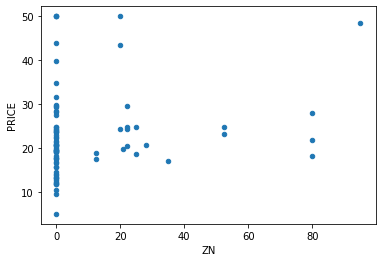

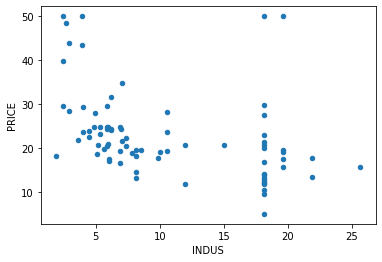

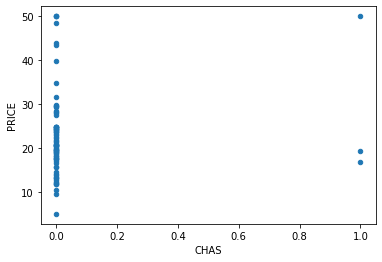

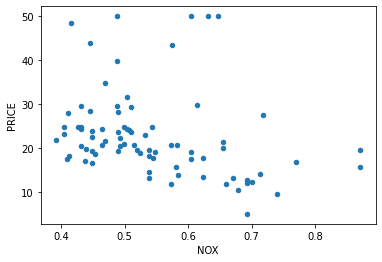

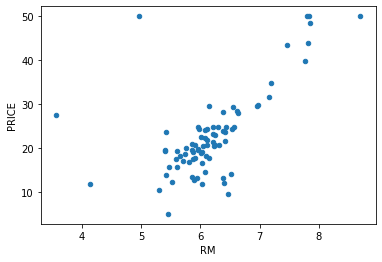

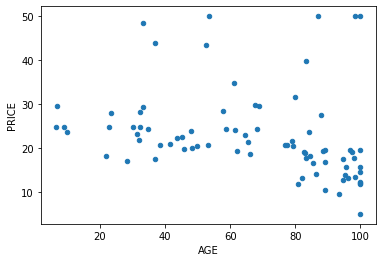

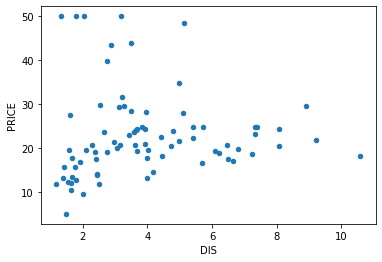

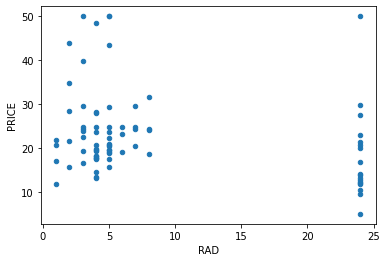

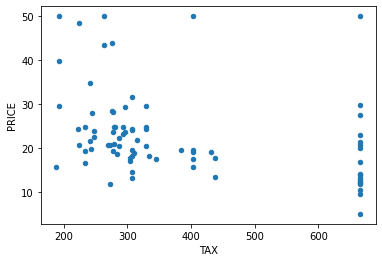

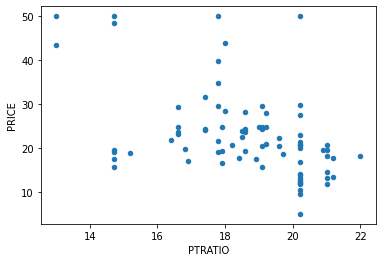

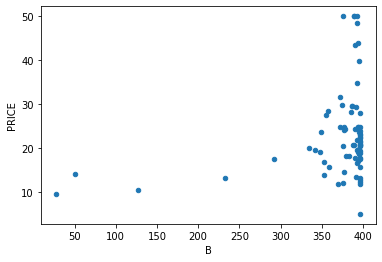

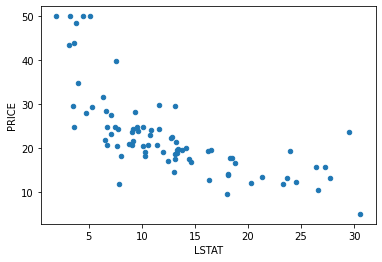

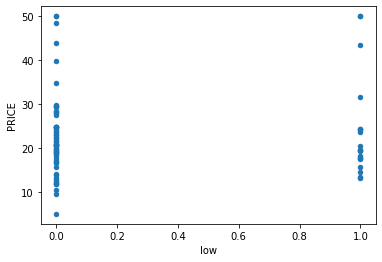

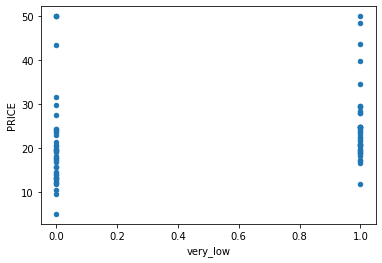

In [9]:
# 8-8 「各特徴量の列」と「PRICE列」の相関係数を示す散布図を描く
colname = train_val2.columns
for name in colname:
    if name == 'PRICE':
        continue
    train_val2.plot(kind='scatter', x=name, y='PRICE')

In [11]:
# 8−9 外れ値が存在するインデックスを確認する
# RM
out_line1 = train_val2[
    (train_val2['RM'] < 6) & (train_val2['PRICE'] > 40)
].index
# PTRATIO
out_line2 = train_val2[
    (train_val2['PTRATIO'] > 18) & (train_val2['PRICE'] > 40)
].index

print(out_line1, out_line2)

Int64Index([76], dtype='int64') Int64Index([76], dtype='int64')


In [12]:
# 8-10 外れ値を削除する
train_val3 = train_val2.drop([76], axis=0)

In [13]:
# 8-11 絞り込んだ列以外を取り除く
col = ['INDUS', 'NOX', 'RM', 'PTRATIO', 'LSTAT', 'PRICE']
train_val4 = train_val3[col]
train_val4.head()

,INDUS,NOX,RM,PTRATIO,LSTAT,PRICE
43,5.86,0.431,6.108,19.1,9.16,24.3
62,5.86,0.431,6.957,19.1,3.53,29.6
3,21.89,0.624,6.151,21.2,18.46,17.8
71,3.64,0.392,6.108,16.4,6.57,21.9
45,5.64,0.439,5.963,16.8,13.45,19.7


In [14]:
# 8-12 列同士の相関係数を調べる
train_val4.corr()

,INDUS,NOX,RM,PTRATIO,LSTAT,PRICE
INDUS,1.000000,0.785722,-0.403129,0.249438,0.578406,-0.470889
NOX,0.785722,1.000000,-0.272996,0.077533,0.484295,-0.325289
RM,-0.403129,-0.272996,1.000000,-0.404568,-0.560454,0.753771
PTRATIO,0.249438,0.077533,-0.404568,1.000000,0.326563,-0.542449
LSTAT,0.578406,0.484295,-0.560454,0.326563,1.000000,-0.693490
PRICE,-0.470889,-0.325289,0.753771,-0.542449,-0.693490,1.000000


In [15]:
# 8-13 各列と「PRICE列」との相関係数をみる
train_cor = train_val4.corr()['PRICE']
train_cor

INDUS     -0.470889
NOX       -0.325289
RM         0.753771
PTRATIO   -0.542449
LSTAT     -0.693490
PRICE      1.000000
Name: PRICE, dtype: float64

In [18]:
# 8-16 相関行列の「PRICE列」との相関係数を絶対値に変換する
# abs(train_cor)
abs_cor = train_cor.map(abs)
abs_cor

INDUS      0.470889
NOX        0.325289
RM         0.753771
PTRATIO    0.542449
LSTAT      0.693490
PRICE      1.000000
Name: PRICE, dtype: float64

In [19]:
# 8-17 sort_values()メソッドで要素を降順に並べ替える
abs_cor.sort_values(ascending=False)

PRICE      1.000000
RM         0.753771
LSTAT      0.693490
PTRATIO    0.542449
INDUS      0.470889
NOX        0.325289
Name: PRICE, dtype: float64

In [23]:
# 8-18 訓練データと検証データを分割する
col = ['RM', 'LSTAT', 'PTRATIO']
x = train_val4[col]
t = train_val4[['PRICE']]

x_train, x_val, y_train, y_val = train_test_split(
    x, t, test_size=0.2, random_state=0
)


In [26]:
# 8-19 scikit-learnのpreprocessingモジュールを使う
# データの標準化

# StandardScalerオブジェクトを生成する
sc_model_x = StandardScaler()
# 各列の平均値、標準偏差を調べる
sc_model_x.fit(x_train)


StandardScaler()

In [27]:
# 各列のデータを標準化してsc_xに代入する
sc_x = sc_model_x.transform(x_train)
sc_x

array([[-0.10238334, -0.89546338, -0.97250163],
       [-0.11741281, -0.37386886,  1.21732721],
       [-0.92274224,  2.49984836,  0.83648742],
       [ 1.60346221, -1.37747891, -2.59107078],
       [-0.21134704, -0.36821472, -0.30603198],
       [ 0.28337322, -0.54632017, -0.87729168],
       [ 2.01927772, -1.55275729, -1.7817862 ],
       [-0.42551707, -0.58448562,  0.36043767],
       [-0.39420567,  0.21557535, -1.7817862 ],
       [-0.21886178, -0.00634969,  0.02720284],
       [-0.48438252,  0.24525959,  0.83648742],
       [ 0.02411475,  0.04453758,  0.83648742],
       [ 0.31092726, -1.31669689,  0.31283269],
       [ 2.08315299, -1.28559912, -1.7817862 ],
       [-0.98411261,  1.56550154,  0.07480782],
       [-0.28398951,  0.07704889, -0.78208173],
       [-0.9039554 ,  1.91040415, -1.7817862 ],
       [ 0.23828479,  1.52450902,  0.83648742],
       [-0.12993738, -0.28622968, -0.49645188],
       [-0.18629791, -0.73573389,  0.55085757],
       [-0.37917619,  0.48697412,  0.836

In [30]:
# 8-20 平均値0を確認する
# array型をデータフレームに変換する
tmp_df = pd.DataFrame(sc_x, columns=x_train.columns)
print(tmp_df.head(), "\n")

tmp_df.mean()

         RM     LSTAT   PTRATIO
0 -0.102383 -0.895463 -0.972502
1 -0.117413 -0.373869  1.217327
2 -0.922742  2.499848  0.836487
3  1.603462 -1.377479 -2.591071
4 -0.211347 -0.368215 -0.306032 



RM        -3.418782e-16
LSTAT      1.445052e-16
PTRATIO   -1.436241e-16
dtype: float64

In [31]:
# 8-21 標準偏差1を確認する
tmp_df.std()

RM         1.008032
LSTAT      1.008032
PTRATIO    1.008032
dtype: float64

In [34]:
# 8-22 正解データを標準化する
sc_model_y = StandardScaler()
sc_model_y.fit(y_train)

sc_y = sc_model_y.transform(y_train)
sc_y

array([[-0.05270192],
       [-0.44023557],
       [-1.82278806],
       [ 2.2096567 ],
       [-0.33549674],
       [ 0.12535409],
       [ 2.89045906],
       [-0.14696686],
       [-0.52402663],
       [ 0.01014138],
       [-0.58686992],
       [-0.10507133],
       [ 0.25104068],
       [ 2.73335082],
       [-0.32502286],
       [-0.28312733],
       [-0.71255651],
       [-0.97440357],
       [ 0.16724962],
       [-0.20981015],
       [-1.0162991 ],
       [ 0.7747348 ],
       [ 0.08345856],
       [ 0.5338355 ],
       [-1.2571984 ],
       [ 0.75378703],
       [ 0.75378703],
       [-1.05819463],
       [-0.36691839],
       [ 0.20914515],
       [-0.4821311 ],
       [-0.96392969],
       [-0.29360121],
       [-0.02128027],
       [ 2.89045906],
       [-0.34597063],
       [ 0.19867126],
       [ 0.62810044],
       [-1.34098946],
       [ 2.24107835],
       [ 0.13582797],
       [-1.0791424 ],
       [-0.60781769],
       [ 0.25104068],
       [-0.18886239],
       [ 0

## 8.3 モデルの作成と学習

In [36]:
# 8-23 標準化したデータで学習させる
model = LinearRegression()
model.fit(sc_x, sc_y)

LinearRegression()

## 8.4 モデルの評価とチューニング

In [37]:
# 8-24 score()メソッドで決定係数を求める
model.score(x_val, y_val)

/Users/takeru/Library/CloudStorage/OneDrive-個人用/Learn/Python/Introduction_to_Machine_Learning_with_Python_Imp/ml_env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


-13.085044375040098

In [38]:
# 8-25 検証データを標準化する
sc_x_val = sc_model_x.transform(x_val)
sc_y_val = sc_model_y.transform(y_val)

model.score(sc_x_val, sc_y_val)

0.7359028880291

In [39]:
# 8-27 learn関数を定義する
def learn(x, t):
    x_train, x_val, y_train, y_val = train_test_split(
        x, t, test_size=0.2, random_state=0
    )
    # 訓練データの標準化
    sc_model_x = StandardScaler()
    sc_model_y = StandardScaler()
    sc_model_x.fit(x_train)
    sc_model_y.fit(y_train)
    sc_x_train = sc_model_x.transform(x_train)
    sc_y_train = sc_model_y.transform(y_train)
    # 検証データの標準化
    sc_x_val = sc_model_x.transform(x_val)
    sc_y_val = sc_model_y.transform(y_val)
    # 学習
    model = LinearRegression()
    model.fit(sc_x_train, sc_y_train)
    # 訓練データと検証データの決定係数の計算
    train_score = model.score(sc_x_train, sc_y_train)
    val_score = model.score(sc_x_val, sc_y_val)

    return train_score, val_score

In [40]:
# 8-28 learn関数を実行する
x = train_val3.loc[:, ['RM', 'LSTAT', 'PTRATIO']]
t = train_val3[['PRICE']]

s1, s2 = learn(x, t)
print(s1, s2)

0.717589757251598 0.7359028880291


In [41]:
# 8-29 特徴量に「INDUS列」を追加する（2回目）
x = train_val3.loc[:, ['RM', 'LSTAT', 'PTRATIO', 'INDUS']]
t = train_val3[['PRICE']]

s1, s2 = learn(x, t)
print(s1, s2)

0.7190252930186809 0.7295535344941493


In [42]:
# 8-31 新しい列を特徴量として追加する
x['RM2'] = x['RM'] ** 2

# 「INDUS列」を削除する
x = x.drop('INDUS', axis=1)
x.head()

,RM,LSTAT,PTRATIO,RM2
43,6.108,9.16,19.1,37.307664
62,6.957,3.53,19.1,48.399849
3,6.151,18.46,21.2,37.834801
71,6.108,6.57,16.4,37.307664
45,5.963,13.45,16.8,35.557369


In [43]:
# 8-33 新しい特徴量を含めて再学習する（3回目）
s1, s2 = learn(x, t)
print(s1, s2)

0.8456207631185567 0.8372526287986777


In [45]:
# 8−34 「LSTAT列」と「PTRATIO列」で新しい列を特徴量に追加する(4,5回目)
x['LSTAT2'] = x['LSTAT'] ** 2
s1, s2 = learn(x, t)
print(s1, s2)

x['PTRATIO2'] = x['PTRATIO'] ** 2
s1, s2 = learn(x, t)
print(s1, s2)

0.8565689444345094 0.8425282632102127
0.864383498898444 0.8678022326740729


In [47]:
# 8-36 交互作用特徴量を追加する
x['RM*LSTAT'] = x['RM'] * x['LSTAT']
x.head()

,RM,LSTAT,PTRATIO,RM2,LSTAT2,PTRATIO2,RM*LSTAT
43,6.108,9.16,19.1,37.307664,83.9056,364.81,55.94928
62,6.957,3.53,19.1,48.399849,12.4609,364.81,24.55821
3,6.151,18.46,21.2,37.834801,340.7716,449.44,113.54746
71,6.108,6.57,16.4,37.307664,43.1649,268.96,40.12956
45,5.963,13.45,16.8,35.557369,180.9025,282.24,80.20235


In [48]:
# 8-37 追加した特徴量を含めて再学習を行う（6回目）
s1, s2 = learn(x, t)
print(s1, s2)

0.8668534967796697 0.8739347357775971


In [49]:
# 8-38 データの標準化後に再学習を行う（7回目）

# 訓練データと検証データを合わせて再学習するので、
# 再度、標準化する
sc_model_x2 = StandardScaler()
sc_model_y2 = StandardScaler()
sc_model_x2.fit(x)
sc_model_y2.fit(t)
sc_x = sc_model_x2.transform(x)
sc_y = sc_model_y2.transform(t)

model = LinearRegression()
model.fit(sc_x, sc_y)

LinearRegression()

In [51]:
# 8-39 テストデータの前処理
test2 = test.fillna(test.mean())
x_test = test2.loc[:, ['RM', 'LSTAT', 'PTRATIO']]
y_test = test2[['PRICE']]

x_test['RM2'] = x_test['RM'] ** 2
x_test['LSTAT2'] = x_test['LSTAT'] ** 2
x_test['PTRATIO2'] = x_test['PTRATIO'] ** 2
x_test['RM*LSTAT'] = x_test['RM'] * x_test['LSTAT']

sc_x_test = sc_model_x2.transform(x_test)
sc_y_test = sc_model_y2.transform(y_test)

In [52]:
# 8-40 テストデータで決定係数を計算する
model.score(sc_x_test, sc_y_test)

0.7649249353669053

In [55]:
# 8-41 モデルを保存する
with open('../models/boston/boston.pkl', 'wb') as f:
    pickle.dump(model, f)
with open('../models/boston/boston_scx.pkl', 'wb') as f:
    pickle.dump(sc_model_x2, f)
with open('../models/boston/boston_scy.pkl', 'wb') as f:
    pickle.dump(sc_model_y2, f)